# connect to Drive

In [1]:
#  connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install & import

In [2]:
!pip install torch==2.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [3]:
!python -c "import torch; print(torch.__version__)"


2.2.1+cu121


In [4]:
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.2.1+cu121.html
!pip install torch-geometric
!pip install faiss-gpu

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import argparse
import os
import os.path as osp
import torch
import torch.nn.functional as F
from tqdm import tqdm
import torch_geometric.transforms as T
from torch_geometric import EdgeIndex
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.data import NeighborSampler
from torch_geometric.metrics import (
    LinkPredPrecision,
    LinkPredRecall,
    LinkPredNDCG,
)
from torch_geometric.nn import GCNConv, to_hetero
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import random

# set seeds

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set a random seed for reproducibility
def set_seed():
  seed = 0
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  g=torch.Generator()
  g.manual_seed(seed)
  # Ensure deterministic behavior (may slow down performance slightly)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.use_deterministic_algorithms = True
  CUBLAS_WORKSPACE_CONFIG=':16:8'
  os.environ['CUBLAS_WORKSPACE_CONFIG'] = CUBLAS_WORKSPACE_CONFIG
  os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
g = torch.Generator()
g.manual_seed(seed)
# Ensure deterministic behavior (may slow down performance slightly)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms = True
CUBLAS_WORKSPACE_CONFIG = ':16:8'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = CUBLAS_WORKSPACE_CONFIG
os.environ['PYTHONHASHSEED'] = str(seed)


# Data preparation

we have already created our graph and stored it in drive

In [ ]:
data = torch.load('/content/drive/MyDrive/data/graph/graph_gptl.pt', map_location=torch.device('cpu'))

In [ ]:
print(data)

HeteroData(
  user={
    num_nodes=500,
    x=[500, 768],
  },
  job={
    num_nodes=500,
    x=[500, 768],
  },
  (user, applies, job)={
    edge_index=[2, 977],
    edge_label=[977],
  },
  (user, similar_U, user)={ edge_index=[2, 41920] },
  (job, similar_J, job)={ edge_index=[2, 42232] },
  (job, rev_applies, user)={
    edge_index=[2, 977],
    edge_label=[977],
  }
)


In [ ]:
# Get the number of edges in  graph data
num_edges = data['user', 'applies', 'job'].edge_index.size(1)
# Define the ratio for splitting
train_ratio = 0.8
# Generate train and test indices using train_test_split
train_indices, test_indices = train_test_split(range(num_edges), train_size=train_ratio, random_state=42)
# Convert indices to tensors
train_index = torch.tensor(train_indices)
test_index = torch.tensor(test_indices)

In [ ]:
# for reproductibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
# Set up loaders using train and test indices
kwargs = dict(
    data=data,
    num_neighbors=[-1, -1],
    batch_size=32,
    num_workers=0,
    persistent_workers=False,
    shuffle=False,
    worker_init_fn=seed_worker,  # to ensure reproducibility
    generator=g,
)

train_loader = LinkNeighborLoader(
    edge_label_index=(('user', 'applies', 'job'), data['user', 'applies', 'job'].edge_index[:, train_index]),
    neg_sampling=dict(mode='binary', amount=2),
    **kwargs,
)

# During testing, we sample node-level subgraphs from both endpoints to
# retrieve their embeddings.
# This allows us to do efficient k-NN search on top of embeddings:
src_loader = NeighborLoader(
    input_nodes='user',
    **kwargs,
)
dst_loader = NeighborLoader(
    input_nodes='job',
    **kwargs,
)

# Save test edges and the edges we want to exclude when evaluating:
sparse_size = (data['user'].num_nodes, data['job'].num_nodes)
test_edge_label_index = EdgeIndex(
    data['user', 'applies', 'job'].edge_index[:, test_index].to(device),
    sparse_size=sparse_size,
).sort_by('row')[0]
test_exclude_links = EdgeIndex(
    data['user', 'applies', 'job'].edge_index[:, train_index].to(device),
    sparse_size=sparse_size,
).sort_by('row')[0]


# cosine search

this is the definiction of the search function that is similar to MIPS (maximum inner product search) but with cosine similarity instead of dot product.

In [ ]:
import torch
import warnings
from typing import NamedTuple, Optional
from torch import Tensor
import torch.nn.functional as F

class KNNOutput(NamedTuple):
    score: Tensor
    index: Tensor

class KNNIndex:
    def __init__(
        self,
        emb: Optional[Tensor] = None,
        reserve: Optional[int] = None,
    ):
        warnings.filterwarnings('ignore', '.*TypedStorage is deprecated.*')

        self.index: Optional[Tensor] = None
        self.reserve = reserve

        if emb is not None:
            self.add(emb)

    @property
    def numel(self) -> int:
        if self.index is None:
            return 0
        return self.index.size(0)

    def add(self, emb: Tensor):
        if self.index is None:
            self.index = emb.detach().clone()
        else:
            self.index = torch.cat([self.index, emb.detach()], dim=0)

    def search(
        self,
        emb: Tensor,
        k: int,
        exclude_links: Optional[Tensor] = None,
    ) -> KNNOutput:
        if self.index is None:
            raise RuntimeError(f"'{self.__class__.__name__}' is not yet "
                               "initialized. Please call `add(...)` first.")

        if emb.dim() != 2:
            raise ValueError(f"'emb' needs to be two-dimensional "
                             f"(got {emb.dim()} dimensions)")



        scores = torch.cosine_similarity(emb.unsqueeze(1), self.index.unsqueeze(0), dim=-1)
        scores, indices = torch.topk(scores, k=k, dim=1, largest=True, sorted=True)

        return KNNOutput(scores, indices)

class ApproxCosineKNNIndex(KNNIndex):
    def __init__(
        self,
        emb: Optional[Tensor] = None,
        reserve: Optional[int] = None,
    ):
        super().__init__(emb=emb, reserve=reserve)


# model training

In [ ]:
#set k value
k=10

## model definition

In [ ]:
class GCN_2(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class CosineSimilarityDecoder(torch.nn.Module):
    def forward(self, x_dict, edge_label_index):
        x_src = x_dict['user'][edge_label_index[0]]
        x_dst = x_dict['job'][edge_label_index[1]]
        return torch.cosine_similarity(x_src, x_dst, dim=1)


class Model_2(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.encoder = GCN_2(input_dim, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = CosineSimilarityDecoder()

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        x_dict = self.encoder(x_dict, edge_index_dict)
        cosine_similarity = self.decoder(x_dict, edge_label_index)
        return cosine_similarity



In [ ]:
class GCN_3(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x

class CosineSimilarityDecoder(torch.nn.Module):
    def forward(self, x_dict, edge_label_index):
        x_src = x_dict['user'][edge_label_index[0]]
        x_dst = x_dict['job'][edge_label_index[1]]
        return torch.cosine_similarity(x_src, x_dst, dim=1)


class Model_3(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.encoder = GCN_3(input_dim, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = CosineSimilarityDecoder()

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        x_dict = self.encoder(x_dict, edge_index_dict)
        cosine_similarity = self.decoder(x_dict, edge_label_index)
        return cosine_similarity


In [ ]:
class GCN_5(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index)
        return x

class CosineSimilarityDecoder(torch.nn.Module):
    def forward(self, x_dict, edge_label_index):
        x_src = x_dict['user'][edge_label_index[0]]
        x_dst = x_dict['job'][edge_label_index[1]]
        return torch.cosine_similarity(x_src, x_dst, dim=1)


class Model_5(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.encoder = GCN_5(input_dim, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = CosineSimilarityDecoder()

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        x_dict = self.encoder(x_dict, edge_index_dict)
        cosine_similarity = self.decoder(x_dict, edge_label_index)
        return cosine_similarity


## training

In [ ]:
def train():

    model.train()

    total_loss = total_examples = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['user', 'job'].edge_label_index,
        )
        y = batch['user', 'job'].edge_label

        loss = F.binary_cross_entropy_with_logits(out, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * y.numel()
        total_examples += y.numel()

    return total_loss / total_examples



## test

In [ ]:
@torch.no_grad()
def test(edge_label_index, exclude_links):
    model.eval()

    dst_embs = []
    for batch in dst_loader:
        batch = batch.to(device)
        emb = model.encoder(batch.x_dict, batch.edge_index_dict)['job']
        emb = emb[:batch['job'].batch_size]
        dst_embs.append(emb)
    dst_emb = torch.cat(dst_embs, dim=0)

    index = ApproxCosineKNNIndex(dst_emb)

    ndcg_metric = LinkPredNDCG(k=k).to(device)
    precision_metric = LinkPredPrecision(k=k).to(device)
    recall_metric = LinkPredRecall(k=k).to(device)

    true_values = []
    predicted_values = []

    num_processed = 0
    for batch in src_loader:
        batch = batch.to(device)

        emb = model.encoder(batch.x_dict, batch.edge_index_dict)['user']
        emb = emb[:batch['user'].batch_size]

        _edge_label_index = edge_label_index.sparse_narrow(
            dim=0,
            start=num_processed,
            length=emb.size(0),
        )
        _exclude_links = exclude_links.sparse_narrow(
            dim=0,
            start=num_processed,
            length=emb.size(0),
        )
        num_processed += emb.size(0)

        output = index.search(emb, dst_emb.size(0), _exclude_links)

        ndcg_metric.update(output.index[:, :k], _edge_label_index)
        precision_metric.update(output.index[:, :k], _edge_label_index)
        recall_metric.update(output.index[:, :k], _edge_label_index)

        true_values.append(_edge_label_index.to_dense().cpu())
        predicted_values.append(output.score.cpu())

    true_values = torch.cat(true_values, dim=0)
    predicted_values = torch.cat(predicted_values, dim=0)

    mse = F.mse_loss(predicted_values, true_values)
    rmse = torch.sqrt(mse)

    mae = F.l1_loss(predicted_values, true_values)

    ndcg = float(ndcg_metric.compute())
    precision = float(precision_metric.compute())
    recall = float(recall_metric.compute())

    return (
        ndcg,
        precision,
        recall,
        rmse.item(),
        mae.item(),
    )




# train loop

In [ ]:
# Define the models
models = [Model_2, Model_3, Model_5]

# Hidden channels to test
hidden_channels_list = [32, 64, 128, 256]

# Initialize an empty list to store the results
results_list = []

for model_class in models:
    for hidden_ch in hidden_channels_list:
        set_seed()
        model = model_class(input_dim=768, hidden_channels=hidden_ch).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for num_epochs in range(1, 51):
            set_seed()
            # Train the model for the current epoch and calculate the training loss
            train_loss = train()
            print(f'Model: {model_class.__name__}, Epochs: {num_epochs}, Hidden Channels: {hidden_ch}, Loss: {train_loss:.4f}\n')

            # save model
            torch.save(model, f'/content/drive/MyDrive/models/model_epoch_{num_epochs}_model_{model_class}_hidden_{hidden_ch}.pt')

            # Test the model and calculate evaluation metrics
            ndcg, precision, recall, rmse, mae = test(test_edge_label_index, test_exclude_links)
            print(f'Model: {model_class.__name__}, Epochs: {num_epochs}, Hidden Channels: {hidden_ch}')

            # Append the results to the list with the model name, hidden channel size, and number of epochs
            results_list.append({
                'Model': model_class.__name__,
                'Hidden_Channel': hidden_ch,
                'Epochs': num_epochs,
                'NDCG@10': ndcg,
                'Precision@10': precision,
                'Recall@10': recall,
                'RMSE': rmse,
                'MAE': mae,
            })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Print the results DataFrame
print(results_df)

results_df.to_csv('/content/drive/MyDrive/data/results_layer_hidden_epoch_stable.csv')


# results

In [ ]:
results_df=pd.read_csv('/content/drive/MyDrive/data/results_layer_hidden_epoch_stable.csv')

In [ ]:
# Sorting the DataFrame by NDCG@10, MAE (ascending), Precision@10, Recall@10, RMSE (ascending)
df = results_df.sort_values(by=['NDCG@10', 'MAE', 'Precision@10', 'Recall@10', 'RMSE'], ascending=[False, True, False, False, True])

# Printing the first row (excluding the first column which is likely an index)
print(df.iloc[0, 1:])


Model              Model_2
Hidden_Channel          32
Epochs                  50
NDCG@10           0.138373
Precision@10      0.030909
Recall@10         0.253535
RMSE              0.611069
MAE                0.54254
Name: 49, dtype: object


# test best models for 60 epochs

In [ ]:
res=[]
set_seed()
model = Model_2(input_dim=768, hidden_channels= 32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for num_epochs in range(1, 61):
            set_seed()
            # Train the model for the current epoch and calculate the training loss
            train_loss = train()
            print(f'Epochs: {num_epochs}, Loss: {train_loss:.4f}\n')

            #save model
            #torch.save(model, f'/content/drive/MyDrive/models/model_epoch_{num_epochs}_model_{model_class}_hidden_{hidden_ch}.pt')

            # Test the model and calculate evaluation metrics
            ndcg, precision, recall, rmse, mae = test(test_edge_label_index, test_exclude_links)
            print(f'NDCG@10 : {ndcg:.4f}, Precision@10 : {precision:.4f}, Recall@10 : {recall:.4f}')
            print(f'RMSE : {rmse:.4f}, MAE : {mae:.4f}')
            res.append({
                'Epochs': num_epochs,
                'NDCG@10': ndcg,
                'Precision@10': precision,
                'Recall@10': recall,
                'RMSE': rmse,
                'MAE': mae,
            })
res=pd.DataFrame(res)
res.to_csv('/content/drive/MyDrive/data/stable_results_model2_epochs.csv')
print(res)


100%|██████████| 25/25 [00:07<00:00,  3.51it/s]


Epochs: 1, Loss: 0.6035

NDCG@10 : 0.0000, Precision@10 : 0.0000, Recall@10 : 0.0000
RMSE : 0.6416, MAE : 0.5355


100%|██████████| 25/25 [00:07<00:00,  3.43it/s]


Epochs: 2, Loss: 0.5821

NDCG@10 : 0.0093, Precision@10 : 0.0030, Recall@10 : 0.0273
RMSE : 0.6461, MAE : 0.5170


100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


Epochs: 3, Loss: 0.5749

NDCG@10 : 0.0194, Precision@10 : 0.0061, Recall@10 : 0.0576
RMSE : 0.6348, MAE : 0.5117


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Epochs: 4, Loss: 0.5689

NDCG@10 : 0.0196, Precision@10 : 0.0055, Recall@10 : 0.0515
RMSE : 0.6686, MAE : 0.5681


100%|██████████| 25/25 [00:06<00:00,  3.99it/s]


Epochs: 5, Loss: 0.5636

NDCG@10 : 0.0254, Precision@10 : 0.0073, Recall@10 : 0.0697
RMSE : 0.6580, MAE : 0.5692


100%|██████████| 25/25 [00:06<00:00,  3.62it/s]


Epochs: 6, Loss: 0.5577

NDCG@10 : 0.0340, Precision@10 : 0.0085, Recall@10 : 0.0788
RMSE : 0.6338, MAE : 0.5617


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Epochs: 7, Loss: 0.5512

NDCG@10 : 0.0405, Precision@10 : 0.0091, Recall@10 : 0.0848
RMSE : 0.6084, MAE : 0.5480


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


Epochs: 8, Loss: 0.5364

NDCG@10 : 0.0489, Precision@10 : 0.0115, Recall@10 : 0.1030
RMSE : 0.5961, MAE : 0.5367


100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Epochs: 9, Loss: 0.5268

NDCG@10 : 0.0502, Precision@10 : 0.0127, Recall@10 : 0.1131
RMSE : 0.5941, MAE : 0.5346


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Epochs: 10, Loss: 0.5199

NDCG@10 : 0.0573, Precision@10 : 0.0145, Recall@10 : 0.1242
RMSE : 0.5917, MAE : 0.5328


100%|██████████| 25/25 [00:06<00:00,  3.68it/s]


Epochs: 11, Loss: 0.5166

NDCG@10 : 0.0670, Precision@10 : 0.0182, Recall@10 : 0.1525
RMSE : 0.5900, MAE : 0.5283


100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


Epochs: 12, Loss: 0.5133

NDCG@10 : 0.0755, Precision@10 : 0.0218, Recall@10 : 0.1838
RMSE : 0.5868, MAE : 0.5250


100%|██████████| 25/25 [00:07<00:00,  3.19it/s]


Epochs: 13, Loss: 0.5088

NDCG@10 : 0.0800, Precision@10 : 0.0206, Recall@10 : 0.1717
RMSE : 0.5938, MAE : 0.5316


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Epochs: 14, Loss: 0.5072

NDCG@10 : 0.0762, Precision@10 : 0.0194, Recall@10 : 0.1626
RMSE : 0.6082, MAE : 0.5438


100%|██████████| 25/25 [00:07<00:00,  3.56it/s]


Epochs: 15, Loss: 0.5052

NDCG@10 : 0.0790, Precision@10 : 0.0212, Recall@10 : 0.1732
RMSE : 0.6097, MAE : 0.5448


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Epochs: 16, Loss: 0.5028

NDCG@10 : 0.0646, Precision@10 : 0.0164, Recall@10 : 0.1348
RMSE : 0.6196, MAE : 0.5545


100%|██████████| 25/25 [00:06<00:00,  3.73it/s]


Epochs: 17, Loss: 0.5022

NDCG@10 : 0.0843, Precision@10 : 0.0212, Recall@10 : 0.1879
RMSE : 0.6159, MAE : 0.5520


100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Epochs: 18, Loss: 0.5018

NDCG@10 : 0.0865, Precision@10 : 0.0200, Recall@10 : 0.1788
RMSE : 0.6193, MAE : 0.5570


100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


Epochs: 19, Loss: 0.4997

NDCG@10 : 0.0956, Precision@10 : 0.0224, Recall@10 : 0.1970
RMSE : 0.6113, MAE : 0.5454


100%|██████████| 25/25 [00:07<00:00,  3.57it/s]


Epochs: 20, Loss: 0.4942

NDCG@10 : 0.0935, Precision@10 : 0.0206, Recall@10 : 0.1859
RMSE : 0.6111, MAE : 0.5437


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Epochs: 21, Loss: 0.4917

NDCG@10 : 0.0971, Precision@10 : 0.0212, Recall@10 : 0.1889
RMSE : 0.6183, MAE : 0.5508


100%|██████████| 25/25 [00:06<00:00,  3.70it/s]


Epochs: 22, Loss: 0.4908

NDCG@10 : 0.0933, Precision@10 : 0.0218, Recall@10 : 0.1949
RMSE : 0.6099, MAE : 0.5404


100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


Epochs: 23, Loss: 0.4870

NDCG@10 : 0.0945, Precision@10 : 0.0224, Recall@10 : 0.1929
RMSE : 0.6138, MAE : 0.5422


100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


Epochs: 24, Loss: 0.4861

NDCG@10 : 0.1016, Precision@10 : 0.0236, Recall@10 : 0.2091
RMSE : 0.6155, MAE : 0.5433


100%|██████████| 25/25 [00:06<00:00,  3.60it/s]


Epochs: 25, Loss: 0.4857

NDCG@10 : 0.0951, Precision@10 : 0.0212, Recall@10 : 0.1919
RMSE : 0.6172, MAE : 0.5444


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Epochs: 26, Loss: 0.4887

NDCG@10 : 0.1125, Precision@10 : 0.0224, Recall@10 : 0.1889
RMSE : 0.6035, MAE : 0.5305


100%|██████████| 25/25 [00:06<00:00,  3.61it/s]


Epochs: 27, Loss: 0.4971

NDCG@10 : 0.0836, Precision@10 : 0.0188, Recall@10 : 0.1667
RMSE : 0.6173, MAE : 0.5457


100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


Epochs: 28, Loss: 0.4926

NDCG@10 : 0.0877, Precision@10 : 0.0200, Recall@10 : 0.1747
RMSE : 0.6047, MAE : 0.5345


100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


Epochs: 29, Loss: 0.4897

NDCG@10 : 0.1001, Precision@10 : 0.0230, Recall@10 : 0.2020
RMSE : 0.6038, MAE : 0.5355


100%|██████████| 25/25 [00:07<00:00,  3.52it/s]


Epochs: 30, Loss: 0.4881

NDCG@10 : 0.1104, Precision@10 : 0.0248, Recall@10 : 0.2111
RMSE : 0.5969, MAE : 0.5292


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Epochs: 31, Loss: 0.4844

NDCG@10 : 0.1100, Precision@10 : 0.0267, Recall@10 : 0.2303
RMSE : 0.5885, MAE : 0.5187


100%|██████████| 25/25 [00:06<00:00,  3.65it/s]


Epochs: 32, Loss: 0.4835

NDCG@10 : 0.1132, Precision@10 : 0.0273, Recall@10 : 0.2323
RMSE : 0.5825, MAE : 0.5133


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Epochs: 33, Loss: 0.4851

NDCG@10 : 0.1175, Precision@10 : 0.0285, Recall@10 : 0.2253
RMSE : 0.5834, MAE : 0.5139


100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


Epochs: 34, Loss: 0.4850

NDCG@10 : 0.1169, Precision@10 : 0.0279, Recall@10 : 0.2232
RMSE : 0.5896, MAE : 0.5228


100%|██████████| 25/25 [00:07<00:00,  3.47it/s]


Epochs: 35, Loss: 0.4823

NDCG@10 : 0.1308, Precision@10 : 0.0291, Recall@10 : 0.2374
RMSE : 0.5871, MAE : 0.5192


100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


Epochs: 36, Loss: 0.4802

NDCG@10 : 0.1344, Precision@10 : 0.0303, Recall@10 : 0.2444
RMSE : 0.5785, MAE : 0.5098


100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


Epochs: 37, Loss: 0.4788

NDCG@10 : 0.1225, Precision@10 : 0.0273, Recall@10 : 0.2283
RMSE : 0.5919, MAE : 0.5234


100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


Epochs: 38, Loss: 0.4764

NDCG@10 : 0.1347, Precision@10 : 0.0261, Recall@10 : 0.2162
RMSE : 0.5926, MAE : 0.5235


100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


Epochs: 39, Loss: 0.4761

NDCG@10 : 0.1232, Precision@10 : 0.0267, Recall@10 : 0.2162
RMSE : 0.5891, MAE : 0.5195


100%|██████████| 25/25 [00:07<00:00,  3.54it/s]


Epochs: 40, Loss: 0.4748

NDCG@10 : 0.1208, Precision@10 : 0.0273, Recall@10 : 0.2182
RMSE : 0.5960, MAE : 0.5257


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Epochs: 41, Loss: 0.4749

NDCG@10 : 0.1300, Precision@10 : 0.0273, Recall@10 : 0.2182
RMSE : 0.6035, MAE : 0.5337


100%|██████████| 25/25 [00:06<00:00,  3.73it/s]


Epochs: 42, Loss: 0.4749

NDCG@10 : 0.1267, Precision@10 : 0.0273, Recall@10 : 0.2242
RMSE : 0.6086, MAE : 0.5387


100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


Epochs: 43, Loss: 0.4727

NDCG@10 : 0.1288, Precision@10 : 0.0285, Recall@10 : 0.2333
RMSE : 0.6292, MAE : 0.5604


100%|██████████| 25/25 [00:07<00:00,  3.19it/s]


Epochs: 44, Loss: 0.4707

NDCG@10 : 0.1163, Precision@10 : 0.0261, Recall@10 : 0.2162
RMSE : 0.6234, MAE : 0.5553


100%|██████████| 25/25 [00:07<00:00,  3.47it/s]


Epochs: 45, Loss: 0.4693

NDCG@10 : 0.1212, Precision@10 : 0.0273, Recall@10 : 0.2283
RMSE : 0.6187, MAE : 0.5514


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Epochs: 46, Loss: 0.4683

NDCG@10 : 0.1261, Precision@10 : 0.0309, Recall@10 : 0.2465
RMSE : 0.6102, MAE : 0.5422


100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


Epochs: 47, Loss: 0.4705

NDCG@10 : 0.1348, Precision@10 : 0.0339, Recall@10 : 0.2657
RMSE : 0.5918, MAE : 0.5214


100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Epochs: 48, Loss: 0.4695

NDCG@10 : 0.1156, Precision@10 : 0.0291, Recall@10 : 0.2354
RMSE : 0.6061, MAE : 0.5373


100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


Epochs: 49, Loss: 0.4673

NDCG@10 : 0.1374, Precision@10 : 0.0345, Recall@10 : 0.2747
RMSE : 0.6051, MAE : 0.5359


100%|██████████| 25/25 [00:07<00:00,  3.52it/s]


Epochs: 50, Loss: 0.4684

NDCG@10 : 0.1384, Precision@10 : 0.0309, Recall@10 : 0.2535
RMSE : 0.6111, MAE : 0.5425


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Epochs: 51, Loss: 0.4671

NDCG@10 : 0.1315, Precision@10 : 0.0315, Recall@10 : 0.2515
RMSE : 0.6053, MAE : 0.5366


100%|██████████| 25/25 [00:06<00:00,  3.74it/s]


Epochs: 52, Loss: 0.4687

NDCG@10 : 0.1068, Precision@10 : 0.0255, Recall@10 : 0.2172
RMSE : 0.6143, MAE : 0.5464


100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Epochs: 53, Loss: 0.4669

NDCG@10 : 0.1064, Precision@10 : 0.0255, Recall@10 : 0.2091
RMSE : 0.6226, MAE : 0.5562


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Epochs: 54, Loss: 0.4653

NDCG@10 : 0.1181, Precision@10 : 0.0248, Recall@10 : 0.2111
RMSE : 0.6209, MAE : 0.5531


100%|██████████| 25/25 [00:07<00:00,  3.55it/s]


Epochs: 55, Loss: 0.4651

NDCG@10 : 0.1256, Precision@10 : 0.0261, Recall@10 : 0.2182
RMSE : 0.6188, MAE : 0.5508


100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


Epochs: 56, Loss: 0.4641

NDCG@10 : 0.1165, Precision@10 : 0.0255, Recall@10 : 0.2121
RMSE : 0.6164, MAE : 0.5482


100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


Epochs: 57, Loss: 0.4641

NDCG@10 : 0.1265, Precision@10 : 0.0261, Recall@10 : 0.2182
RMSE : 0.6069, MAE : 0.5379


100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


Epochs: 58, Loss: 0.4638

NDCG@10 : 0.1257, Precision@10 : 0.0255, Recall@10 : 0.2182
RMSE : 0.6159, MAE : 0.5471


100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


Epochs: 59, Loss: 0.4649

NDCG@10 : 0.1193, Precision@10 : 0.0279, Recall@10 : 0.2394
RMSE : 0.6236, MAE : 0.5557


100%|██████████| 25/25 [00:07<00:00,  3.57it/s]


Epochs: 60, Loss: 0.4666

NDCG@10 : 0.1224, Precision@10 : 0.0267, Recall@10 : 0.2253
RMSE : 0.6176, MAE : 0.5493
    Epochs   NDCG@10  Precision@10  Recall@10      RMSE       MAE
0        1  0.000000      0.000000   0.000000  0.641630  0.535457
1        2  0.009260      0.003030   0.027273  0.646147  0.516962
2        3  0.019397      0.006061   0.057576  0.634782  0.511732
3        4  0.019624      0.005455   0.051515  0.668640  0.568100
4        5  0.025435      0.007273   0.069697  0.657982  0.569215
5        6  0.033994      0.008485   0.078788  0.633846  0.561710
6        7  0.040515      0.009091   0.084848  0.608410  0.547973
7        8  0.048936      0.011515   0.103030  0.596148  0.536713
8        9  0.050171      0.012727   0.113131  0.594088  0.534618
9       10  0.057331      0.014545   0.124242  0.591696  0.532827
10      11  0.067014      0.018182   0.152525  0.589959  0.528324
11      12  0.075469      0.021818   0.183838  0.586814  0.524979
12      13  0.080043      0.

In [ ]:
# Sorting the DataFrame by NDCG@10, MAE (ascending), Precision@10, Recall@10, RMSE (ascending)
res.sort_values(by=['NDCG@10', 'MAE', 'Precision@10', 'Recall@10', 'RMSE'], ascending=[False, True, False, False, True]).iloc[0,:]

Epochs          50.000000
NDCG@10          0.138373
Precision@10     0.030909
Recall@10        0.253535
RMSE             0.611069
MAE              0.542540
Name: 49, dtype: float64

In [ ]:
res=res.sort_values(by='Epochs')

# visualisation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sort_order = ['NDCG@10', 'MAE', 'Precision@10', 'Recall@10', 'RMSE']

# Sort by the specified metrics
sorted_df = results_df.sort_values(by=sort_order, ascending=[False, True, False, False, True])

# Group by 'model' and get the top row for each group
max_scores_df = sorted_df.groupby('Model').head(1).reset_index(drop=True)
max_scores_df

,Unnamed: 0,Model,Hidden_Channel,Epochs,NDCG@10,Precision@10,Recall@10,RMSE,MAE
0,49,Model_2,32,50,0.138373,0.030909,0.253535,0.611069,0.542540
1,293,Model_3,64,44,0.104272,0.018788,0.176768,0.667286,0.601197
2,425,Model_5,32,26,0.079526,0.016970,0.141919,0.618977,0.547224


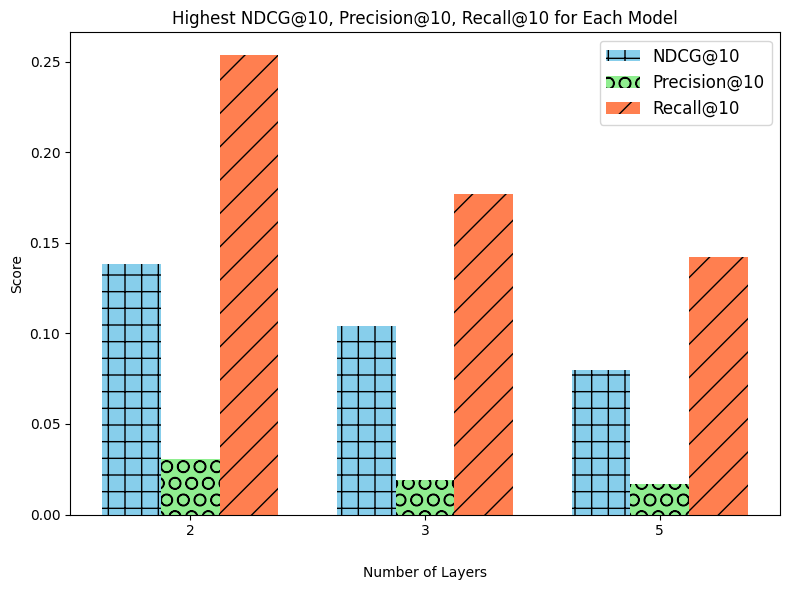

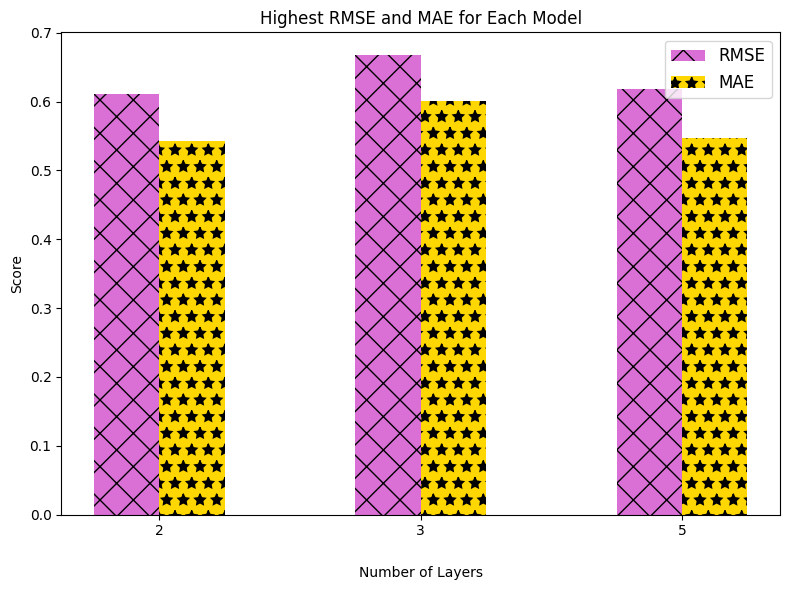

In [ ]:
import numpy as np

# Values for x-axis
num_layers = [2, 3, 5]
index = np.arange(len(num_layers))

# Plotting NDCG@10, Precision@10, Recall@10 in one plot
plt.figure(figsize=(8, 6))

# Setting up bar width
bar_width = 0.25

# Define custom colors and hatch patterns
colors = ['skyblue', 'lightgreen', 'coral']
patterns = ['+', 'O', '/']

# Plotting NDCG@10
plt.bar(index - bar_width, max_scores_df['NDCG@10'], bar_width, color=colors[0], label='NDCG@10', hatch=patterns[0])

# Plotting Precision@10
plt.bar(index, max_scores_df['Precision@10'], bar_width, color=colors[1], label='Precision@10', hatch=patterns[1])

# Plotting Recall@10
plt.bar(index + bar_width, max_scores_df['Recall@10'], bar_width, color=colors[2], label='Recall@10', hatch=patterns[2])

# Adding labels and title
plt.xlabel('Number of Layers', labelpad=20)
plt.ylabel('Score')
plt.title('Highest NDCG@10, Precision@10, Recall@10 for Each Model')
plt.xticks(index, num_layers)
plt.legend(fontsize='large')
plt.tight_layout()

# Saving the plot
plt.savefig('/content/drive/MyDrive/data/stable_highest_metrics_ndcg_precision_recall.png')

# Showing the plot
plt.show()

# Plotting RMSE and MAE in another plot
plt.figure(figsize=(8, 6))

# Define custom colors and hatch patterns for RMSE and MAE
colors = ['orchid', 'gold']
patterns = ['x', '*']

# Plotting RMSE
plt.bar(index - bar_width/2, max_scores_df['RMSE'], bar_width, color=colors[0], label='RMSE', hatch=patterns[0])

# Plotting MAE
plt.bar(index + bar_width/2, max_scores_df['MAE'], bar_width, color=colors[1], label='MAE', hatch=patterns[1])

# Adding labels and title
plt.xlabel('Number of Layers', labelpad=20)
plt.ylabel('Score')
plt.title('Highest RMSE and MAE for Each Model')
plt.xticks(index, num_layers)
plt.legend(fontsize='large')
plt.tight_layout()

# Saving the plot
plt.savefig('/content/drive/MyDrive/data/stable_highest_metrics_rmse_mae.png')

# Showing the plot
plt.show()


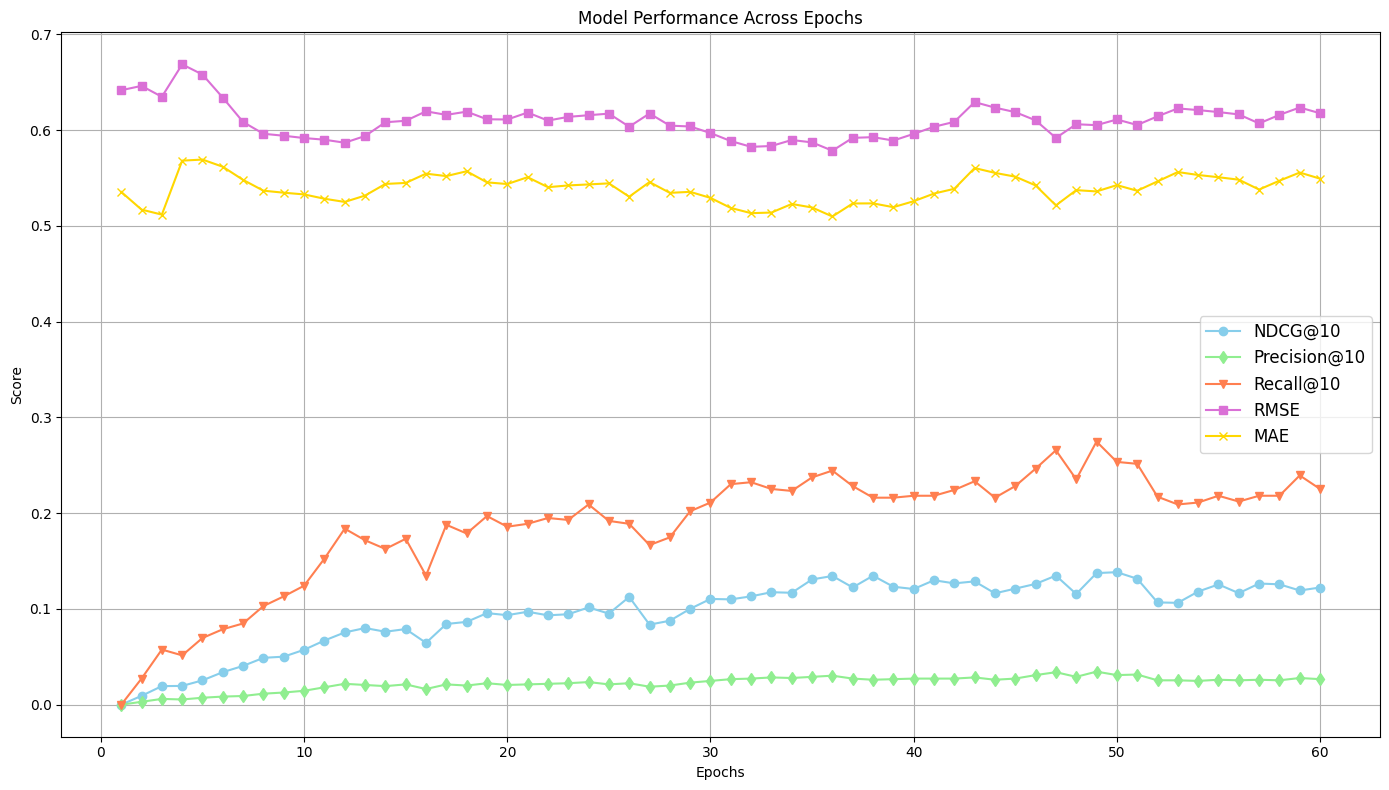

In [ ]:
# Colors for the plot
colors = ['skyblue', 'lightgreen', 'coral', 'orchid', 'gold']

# Plotting all metrics
plt.figure(figsize=(14, 8))

# Plotting NDCG@10
plt.plot(res['Epochs'], res['NDCG@10'], marker='o', label='NDCG@10', color=colors[0])

# Plotting Precision@10
plt.plot(res['Epochs'], res['Precision@10'], marker='d', label='Precision@10', color=colors[1])

# Plotting Recall@10
plt.plot(res['Epochs'], res['Recall@10'], marker='v', label='Recall@10', color=colors[2])

# Plotting RMSE
plt.plot(res['Epochs'], res['RMSE'], marker='s', label='RMSE', color=colors[3])

# Plotting MAE
plt.plot(res['Epochs'], res['MAE'], marker='x', label='MAE', color=colors[4])

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Model Performance Across Epochs')
plt.grid(True)
plt.legend(fontsize='large')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/data/stable_model_performance_epoch.png')
# Show plot
plt.show()


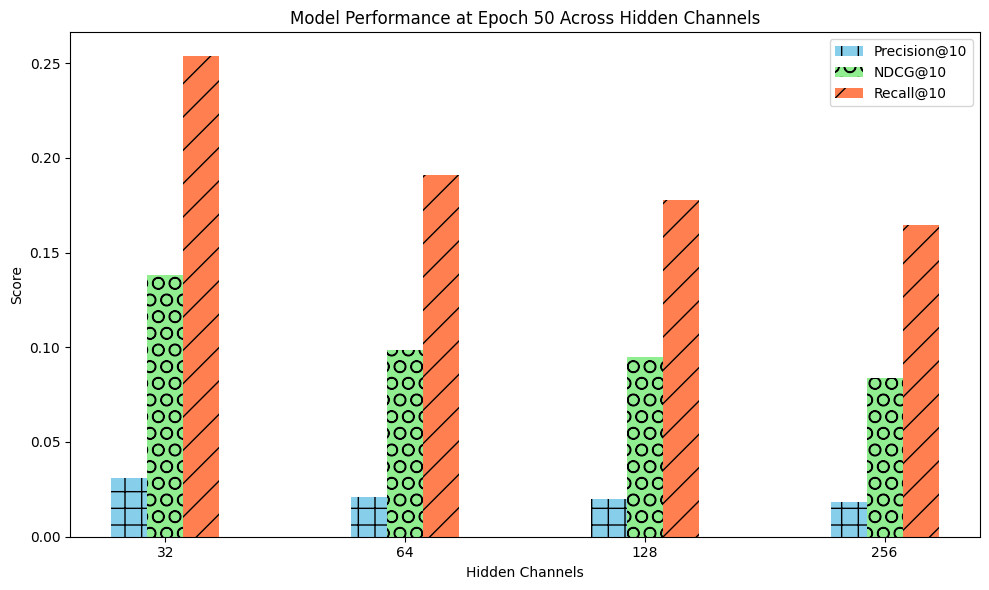

In [ ]:
# Selecting data for Model 2 at epoch 46
model2_epoch50_df = results_df[(results_df['Model'] == 'Model_2') & (results_df['Epochs'] == 50)]

# Plotting all metrics in one plot
plt.figure(figsize=(10, 6))

# Setting up bar width and index
bar_width = 0.15
index = np.arange(len(model2_epoch50_df['Hidden_Channel']))

# Define custom colors and hatch patterns
colors = ['skyblue', 'lightgreen', 'coral']
patterns = ['+', 'O', '/']

# Plotting Precision
plt.bar(index - bar_width, model2_epoch50_df['Precision@10'], bar_width, color=colors[0], label='Precision@10', hatch=patterns[0])

# Plotting NDCG
plt.bar(index, model2_epoch50_df['NDCG@10'], bar_width, color=colors[1], label='NDCG@10', hatch=patterns[1])

# Plotting Recall
plt.bar(index + bar_width, model2_epoch50_df['Recall@10'], bar_width, color=colors[2], label='Recall@10', hatch=patterns[2])

# Adding labels and title
plt.xlabel('Hidden Channels')
plt.ylabel('Score')
plt.title('Model Performance at Epoch 50 Across Hidden Channels')
plt.xticks(index, model2_epoch50_df['Hidden_Channel'])
plt.legend()

# Adjusting the legend handles for custom colors and patterns
import matplotlib.patches as mpatches
handles = [mpatches.Patch(facecolor=colors[i], label=f'{label} - {patterns[i]}') for i, label in enumerate(['Precision@10', 'NDCG@10', 'Recall@10'])]
plt.legend()

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/data/stable_model_performance_hidden_channel.png')
plt.show()


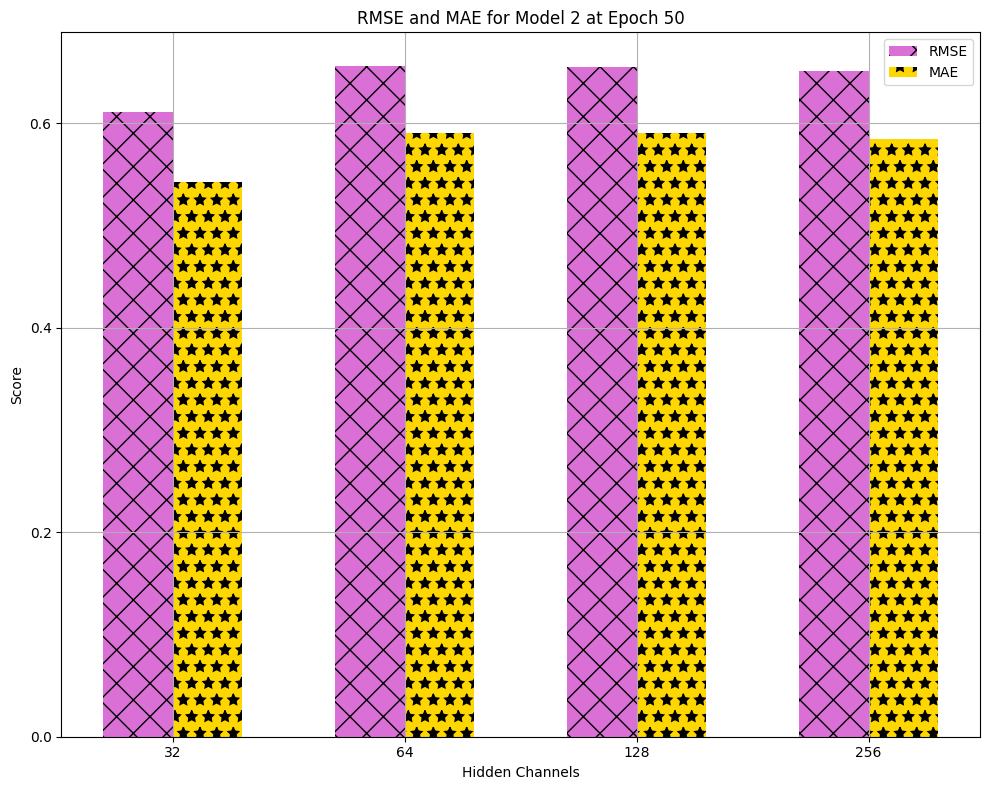

In [ ]:
# Plotting RMSE and MAE together
plt.figure(figsize=(10, 8))

# Setting up bar width and index
bar_width = 0.3
index = np.arange(len(model2_epoch50_df['Hidden_Channel']))
colors = ['orchid', 'gold']
patterns = ['x', '*']
# Plotting RMSE
plt.bar(index - bar_width/2, model2_epoch50_df['RMSE'], bar_width, color=colors[0], label='RMSE', hatch=patterns[0])

# Plotting MAE
plt.bar(index + bar_width/2, model2_epoch50_df['MAE'], bar_width, color=colors[1], label='MAE', hatch=patterns[1])

# Adding labels and title
plt.xlabel('Hidden Channels')
plt.ylabel('Score')
plt.title('RMSE and MAE for Model 2 at Epoch 50')
plt.xticks(index, model2_epoch50_df['Hidden_Channel'])
plt.yticks(np.arange(0, 0.8, 0.2))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/stable_model_performance_hidden_channel_rmse_mae.png')
plt.show()


# recommendation

In [8]:
def recommend_top_k(user_id, data, model, k=10):
    # Get user features for the given user ID
    user_features = data['user']['x'][user_id]

    # Encode user and job features using the model
    encoded_data = model.encoder(data.x_dict, data.edge_index_dict)
    user_embedding = encoded_data['user'][user_id]  # Extract user embedding

    # Find jobs that the user has interacted with
    user_interacted_jobs = data['user', 'applies', 'job'].edge_index[1][data['user', 'applies', 'job'].edge_index[0] == user_id]

    # Get all job IDs
    all_job_ids = torch.arange(data['job'].num_nodes)

    # Remove jobs that the user has interacted with
    candidate_job_ids = all_job_ids[~torch.isin(all_job_ids, user_interacted_jobs)]

    # Adjust k if it exceeds the number of candidate jobs
    k = min(k, len(candidate_job_ids))

    # Create a tensor with the same length as candidate_job_ids, filled with user_id
    user_id_tensor = torch.full((len(candidate_job_ids),), user_id, dtype=torch.long)

    # Calculate recommendation scores using model's decoder
    recommendation_scores = model.decoder(encoded_data, (user_id_tensor, candidate_job_ids))

    # Extract top-k job IDs with highest recommendation scores
    top_k_values, top_k_indices = torch.topk(recommendation_scores, k, largest=True, sorted=True)
    top_k_job_ids = candidate_job_ids[top_k_indices].tolist()

    return top_k_job_ids

# recommendation example

In [9]:
data =torch.load('/content/drive/MyDrive/data/graph/graph_gptl.pt', map_location=torch.device('cpu'))
print(data)

HeteroData(
  user={
    num_nodes=500,
    x=[500, 768],
  },
  job={
    num_nodes=500,
    x=[500, 768],
  },
  (user, applies, job)={
    edge_index=[2, 977],
    edge_label=[977],
  },
  (user, similar_U, user)={ edge_index=[2, 41920] },
  (job, similar_J, job)={ edge_index=[2, 42232] },
  (job, rev_applies, user)={
    edge_index=[2, 977],
    edge_label=[977],
  }
)


In [10]:
class GCN_2(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class CosineSimilarityDecoder(torch.nn.Module):
    def forward(self, x_dict, edge_label_index):
        x_src = x_dict['user'][edge_label_index[0]]
        x_dst = x_dict['job'][edge_label_index[1]]
        return torch.cosine_similarity(x_src, x_dst, dim=1)


class Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.encoder = GCN_2(input_dim, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = CosineSimilarityDecoder()

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        x_dict = self.encoder(x_dict, edge_index_dict)
        cosine_similarity = self.decoder(x_dict, edge_label_index)
        return cosine_similarity

In [11]:
model = torch.load('/content/drive/MyDrive/models/Best_model.pt')
print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__applies__job): SAGEConv(768, 32, aggr=mean)
      (user__similar_U__user): SAGEConv(768, 32, aggr=mean)
      (job__similar_J__job): SAGEConv(768, 32, aggr=mean)
      (job__rev_applies__user): SAGEConv(768, 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__applies__job): SAGEConv(32, 32, aggr=mean)
      (user__similar_U__user): SAGEConv(32, 32, aggr=mean)
      (job__similar_J__job): SAGEConv(32, 32, aggr=mean)
      (job__rev_applies__user): SAGEConv(32, 32, aggr=mean)
    )
  )
  (decoder): CosineSimilarityDecoder()
)


In [12]:
users=pd.read_csv('/content/drive/MyDrive/data/chatgpt_datasets/processed_users.csv')
jobs=pd.read_csv('/content/drive/MyDrive/data/chatgpt_datasets/processed_jobs.csv')

In [38]:
# usage example
user_id = 1
top_k_recommendations = recommend_top_k(user_id,data, model,k=10)
print("Top recommendations for user", user_id, ":", top_k_recommendations)

Top recommendations for user 1 : [95, 458, 481, 449, 48, 14, 58, 167, 144, 472]


In [39]:
users.loc[users['userID'] == user_id, ['userID', 'Resume']]

,userID,Resume
1,1,Marketing professional with expertise in socia...


In [40]:
jobs.loc[jobs['jobID'].isin(top_k_recommendations), ['jobID', 'Description','Requirement']]

,jobID,Description,Requirement
14,14,Content Writer,"Bachelor's degree in English, Journalism, or r..."
48,48,Special Education Teacher,Bachelor's degree in Special Education or rela...
58,58,UX Researcher,"Bachelor's degree in Psychology, Human-Compute..."
95,95,Corporate Trainer,"Bachelor's degree in Education, Business Admin..."
144,144,Social Media Specialist,"Bachelor's degree in Marketing, Communications..."
167,167,Email Marketing Specialist,"Bachelor's degree in Marketing, Communications..."
449,449,Email Marketing Manager,"Bachelor's degree in Marketing, Communications..."
458,458,Email Marketing Specialist,"Bachelor's degree in Marketing, Communications..."
472,472,Content Marketing Manager,"Bachelor's degree in Marketing, Communications..."
481,481,Corporate Trainer,"Bachelor's degree in Education, Business Admin..."
